In [3]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

#Import some packages for visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler

In [50]:
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV

In [6]:
# path to the dataset
file_path = "Dry_Eye_Dataset.csv"

# Load the latest version of the file
df0 = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "dakshnagra/dry-eye-disease",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

/var/folders/h4/8_8xkn4579zbrdb79s7zrtl00000gp/T/ipykernel_71785/3521891120.py:5: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df0 = kagglehub.load_dataset(


In [7]:
df = df0.copy()

#Make everything lower case, and replace space with '_'
df.columns = [col.lower().replace(" ", "_").replace("-", "_").replace("itchiness/irritation_in_eye", 'eye_irritation') for col in df.columns]

# Split the blood_pressure column into two new columns
df[['systolic', 'diastolic']] = df['blood_pressure'].str.split('/', expand=True)

# Define the Blood Pressure Category
def categorize_bp(row):
    if 110 <= int(row['systolic']) <= 120 and 70 <= int(row['diastolic']) <= 80:
        return 'normal'
    elif int(row['systolic']) > 120 or int(row['diastolic']) > 80:
        return 'high'
    else:
        return 'low'
# New BP category column
df['bp_category'] = df.apply(categorize_bp, axis=1)

In [8]:
omit_cols = ['blood_pressure',
              'systolic',
              'diastolic']
df = df.drop(columns=omit_cols)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gender                   20000 non-null  object 
 1   age                      20000 non-null  int64  
 2   sleep_duration           20000 non-null  float64
 3   sleep_quality            20000 non-null  int64  
 4   stress_level             20000 non-null  int64  
 5   heart_rate               20000 non-null  int64  
 6   daily_steps              20000 non-null  int64  
 7   physical_activity        20000 non-null  int64  
 8   height                   20000 non-null  int64  
 9   weight                   20000 non-null  int64  
 10  sleep_disorder           20000 non-null  object 
 11  wake_up_during_night     20000 non-null  object 
 12  feel_sleepy_during_day   20000 non-null  object 
 13  caffeine_consumption     20000 non-null  object 
 14  alcohol_consumption   

In [10]:
df.head(20)

,gender,age,sleep_duration,sleep_quality,stress_level,heart_rate,daily_steps,physical_activity,height,weight,...,medical_issue,ongoing_medication,smart_device_before_bed,average_screen_time,blue_light_filter,discomfort_eye_strain,redness_in_eye,eye_irritation,dry_eye_disease,bp_category
0,F,24,9.5,2,1,67,3000,31,161,69,...,Y,Y,N,8.7,N,Y,Y,N,Y,high
1,M,39,9.6,2,3,60,12000,74,164,87,...,Y,Y,N,9.6,Y,N,N,Y,Y,low
2,F,45,5.4,1,5,95,12000,93,179,94,...,N,N,Y,4.0,N,Y,N,N,N,high
3,F,45,5.4,4,5,78,19000,32,160,77,...,Y,N,N,7.6,N,Y,N,Y,N,high
4,F,42,5.7,3,2,72,4000,173,179,99,...,Y,N,N,3.5,N,Y,Y,N,Y,low
5,F,42,5.8,3,1,79,14000,110,174,64,...,Y,Y,Y,2.6,Y,Y,N,Y,Y,high
6,M,26,4.8,5,2,63,6000,42,188,82,...,Y,Y,Y,5.4,Y,N,N,Y,Y,high
7,M,33,5.5,2,1,97,5000,71,162,91,...,N,Y,N,4.5,Y,Y,N,N,Y,high
8,M,36,6.3,1,2,78,7000,142,175,80,...,Y,N,N,3.9,Y,N,N,Y,N,high
9,M,33,7.7,4,5,81,4000,105,163,65,...,Y,Y,N,5.7,N,N,Y,Y,Y,high


In [11]:
categorical_features = list(df.dtypes[df.dtypes == 'object'].index)
for col in categorical_features:
    df[col] = df[col].str.lower()
print(df.iloc[1999])

gender                         m
age                           41
sleep_duration               8.2
sleep_quality                  4
stress_level                   2
heart_rate                    85
daily_steps                11000
physical_activity             48
height                       179
weight                        61
sleep_disorder                 y
wake_up_during_night           n
feel_sleepy_during_day         n
caffeine_consumption           n
alcohol_consumption            n
smoking                        n
medical_issue                  n
ongoing_medication             n
smart_device_before_bed        y
average_screen_time          2.2
blue_light_filter              y
discomfort_eye_strain          n
redness_in_eye                 n
eye_irritation                 y
dry_eye_disease                y
bp_category                 high
Name: 1999, dtype: object


In [12]:
ded = {'n' : 0,
        'y' : 1
      }
df.dry_eye_disease = df.dry_eye_disease.map(ded)

In [13]:
df

,gender,age,sleep_duration,sleep_quality,stress_level,heart_rate,daily_steps,physical_activity,height,weight,...,medical_issue,ongoing_medication,smart_device_before_bed,average_screen_time,blue_light_filter,discomfort_eye_strain,redness_in_eye,eye_irritation,dry_eye_disease,bp_category
0,f,24,9.5,2,1,67,3000,31,161,69,...,y,y,n,8.7,n,y,y,n,1,high
1,m,39,9.6,2,3,60,12000,74,164,87,...,y,y,n,9.6,y,n,n,y,1,low
2,f,45,5.4,1,5,95,12000,93,179,94,...,n,n,y,4.0,n,y,n,n,0,high
3,f,45,5.4,4,5,78,19000,32,160,77,...,y,n,n,7.6,n,y,n,y,0,high
4,f,42,5.7,3,2,72,4000,173,179,99,...,y,n,n,3.5,n,y,y,n,1,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,m,26,9.4,2,3,91,20000,88,200,72,...,y,y,y,3.8,n,y,n,y,1,high
19996,f,39,7.3,3,4,65,2000,53,195,96,...,y,y,n,3.8,n,n,y,n,1,low
19997,f,20,8.0,5,3,78,10000,17,186,87,...,y,n,n,8.4,n,n,y,n,0,high
19998,m,38,4.5,3,3,60,3000,115,170,66,...,n,y,n,2.2,n,n,n,y,1,high


In [14]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [15]:
len(df_train), len(df_test), len(df_val)

(12000, 4000, 4000)

In [16]:
df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

In [17]:
y_train = df_train['dry_eye_disease'].astype(int).values
y_val = df_val['dry_eye_disease'].astype(int).values
y_test = df_test['dry_eye_disease'].astype(int).values #.values converts pandas series to numpy array.

In [18]:
del df_train['dry_eye_disease']
del df_test['dry_eye_disease']
del df_val['dry_eye_disease']

In [19]:
train_dicts = df_train.to_dict(orient = 'records')
val_dicts = df_val.to_dict(orient= 'records')
test_dicts = df_test.to_dict(orient= 'records')

In [20]:
dv = DictVectorizer(sparse = False)
X_train = dv.fit_transform(train_dicts)

In [21]:
X_val = dv.transform(val_dicts)
X_test = dv.transform(test_dicts)

In [22]:
ded_labels = {0: 'no', 1: 'yes'}

In [29]:
classifers = {
              'Random Forest': RandomForestClassifier(max_depth = 10, n_estimators=300, random_state=3),
            #   'SVM': SVC(random_state=3),
            #   'Decision Tree': DecisionTreeClassifier(random_state=3),
              'KNN': KNeighborsClassifier(n_neighbors=30, weights='distance')
             }


Random Forest Classifier:
Training accuracy: 0.717
Cross-validation accuracy: 0.700 (+/- 0.013)
Validation accuracy: 0.696
Test accuracy: 0.694
Precision: 0.687
Recall: 0.694
F1-score: 0.646

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.24      0.36      1391
           1       0.70      0.93      0.80      2609

    accuracy                           0.69      4000
   macro avg       0.68      0.59      0.58      4000
weighted avg       0.69      0.69      0.65      4000



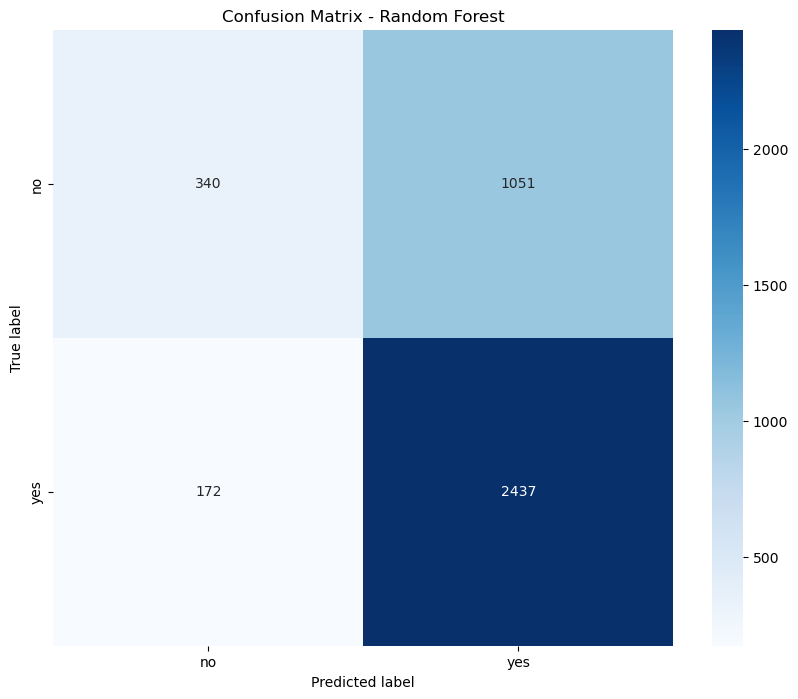


KNN Classifier:
Training accuracy: 1.000
Cross-validation accuracy: 0.639 (+/- 0.014)
Validation accuracy: 0.639
Test accuracy: 0.637
Precision: 0.545
Recall: 0.637
F1-score: 0.534

Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.05      0.08      1391
           1       0.65      0.95      0.77      2609

    accuracy                           0.64      4000
   macro avg       0.50      0.50      0.43      4000
weighted avg       0.54      0.64      0.53      4000



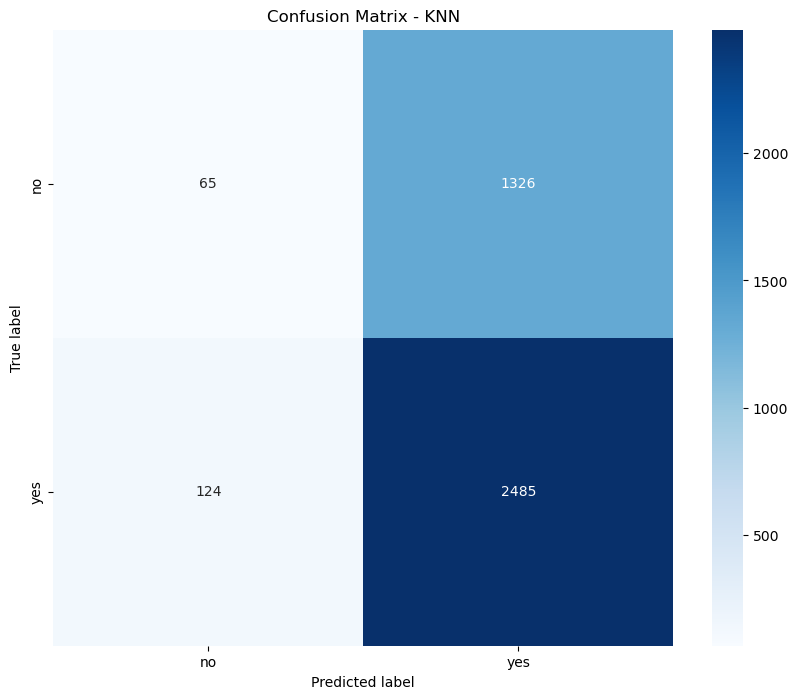

In [30]:
for name, clf in classifers.items():
    
    #5-fold cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=3)
    cv_scores = cross_val_score(clf, X_train, y_train, cv=kfold, scoring='accuracy')
    
    #Fit the model
    
    clf.fit(X_train, y_train)

    #Predicting on training set

    y_pred_train = clf.predict(X_train)
    
    #Predicting on validation set
    
    y_pred_val = clf.predict(X_val)
    
    #Predicting on test set
    
    y_pred_test = clf.predict(X_test)
    
    #Evaluating from the metrics
    
    train_accuracy = accuracy_score(y_train, y_pred_train)
    val_accuracy = accuracy_score(y_val, y_pred_val)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    
    #Calculating the precision, recall, F1-score
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_test, average='weighted', zero_division=0)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred_test)
    
    # Print results
    print(f"\n{name} Classifier:")
    print(f"Training accuracy: {train_accuracy:.3f}")
    print(f"Cross-validation accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    print(f"Validation accuracy: {val_accuracy:.3f}")
    print(f"Test accuracy: {test_accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-score: {f1_score:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_test))
    
     # Plot confusion matrix with labels
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[ded_labels[i] for i in range(len(ded_labels))],
                yticklabels=[ded_labels[i] for i in range(len(ded_labels))])
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## HYPERPARAMETER TUNING

### 1. RANDOM FOREST CLASSIFIER 

In [69]:
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
print(grid_search.best_params_)

{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [1]:
# !pip install shap

In [2]:
# import pandas as pd
# import xgboost as xgb
# import shap

# # Ensure you pass feature names explicitly
# feature_names = dv.get_feature_names_out()  # If using DictVectorizer
# # feature_names = X_train.columns  # If using a DataFrame (before transformation)

# # Train XGBoost model
# xgb_model = xgb.XGBClassifier()
# xgb_model.fit(X_train, y_train)

# # Get feature importances
# importances = xgb_model.feature_importances_

# # Convert to DataFrame for better readability
# feat_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
# feat_importance_df = feat_importance_df.sort_values(by="Importance", ascending=False)

# print(feat_importance_df.head(10))  # Top 10 features

# # ✅ SHAP Analysis (if needed)
# explainer = shap.Explainer(xgb_model, X_train)
# shap_values = explainer(X_train)

# # Plot SHAP summary
# shap.summary_plot(shap_values, features=X_train, feature_names=feature_names)

### 2. XG BOOST CLASSIFIER

In [49]:
# xgb = XGBClassifier(n_estimators=500, max_depth=10, learning_rate=0.05)
# xgb.fit(X_train, y_train)
# print(f"Train accuracy: {xgb.score(X_train, y_train):.3f}")
# print(f"Test accuracy: {xgb.score(X_test, y_test):.3f}")

In [51]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=3)

params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1],
    'colsample_bytree': [0.7, 1]
}

grid = GridSearchCV(xgb, param_grid=params, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
best_xgb = grid.best_estimator_

# Predict
y_pred_test = best_xgb.predict(X_test)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/Users/anweshabasu/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:07:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1738880277541/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/anweshabasu/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:07:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1738880277541/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/anweshabasu/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:07:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1738880277541/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/anweshabasu/miniconda3/envs/erdos_spring_2025/lib/python3.12

Best Parameters: {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.7}


/Users/anweshabasu/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:07:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1738880277541/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


### 3. KNN

In [35]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [41]:
param_grid_knn = {
    'n_neighbors': list(range(3, 50)),
    'weights': ['uniform', 'distance']
}

In [42]:
knn = KNeighborsClassifier()
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_knn.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                         24, 25, 26, 27, 28, 29, 30, 31, 32, ...],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [43]:
print("Best parameters:", grid_search_knn.best_params_)
print("Best cross-validation accuracy:", grid_search_knn.best_score_)

Best parameters: {'n_neighbors': 44, 'weights': 'uniform'}
Best cross-validation accuracy: 0.6806666666666666


In [44]:
best_knn = grid_search_knn.best_estimator_

train_acc = best_knn.score(X_train_scaled, y_train)
val_acc = best_knn.score(X_val_scaled, y_val)
test_acc = best_knn.score(X_test_scaled, y_test)

print(f"Train Accuracy: {train_acc:.2f}")
print(f"Validation Accuracy: {val_acc:.2f}")
print(f"Test Accuracy: {test_acc:.2f}")

Train Accuracy: 0.69
Validation Accuracy: 0.67
Test Accuracy: 0.68


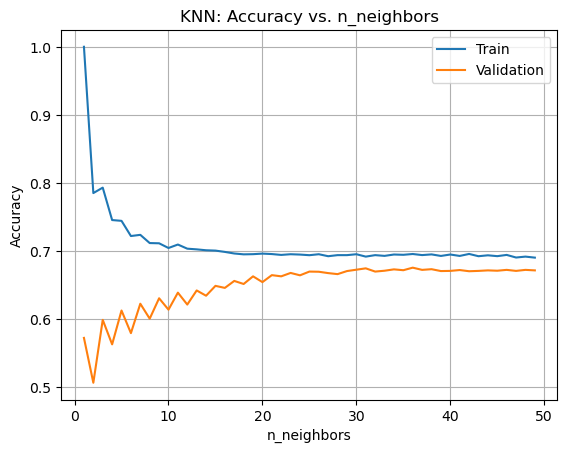

In [47]:
import matplotlib.pyplot as plt

k_range = list(range(1, 50))
train_scores = []
val_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_scores.append(knn.score(X_train_scaled, y_train))
    val_scores.append(knn.score(X_val_scaled, y_val))

plt.plot(k_range, train_scores, label='Train')
plt.plot(k_range, val_scores, label='Validation')
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.legend()
plt.title('KNN: Accuracy vs. n_neighbors')
plt.grid(True)
plt.show()